# **Download and Import Dataset From Kaggle**

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d 'grassknoted/asl-alphabet'


rm: cannot remove '/root/.kaggle': No such file or directory
100% 1.02G/1.03G [00:11<00:00, 149MB/s]
100% 1.03G/1.03G [00:11<00:00, 96.9MB/s]


# **Import Library**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
import shutil
from keras import utils, callbacks
import os
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import cv2
import matplotlib.pyplot
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow_hub as hub



# **Extracting Dataset**

In [ ]:
dataset_zip = zipfile.ZipFile('asl-alphabet.zip')
dataset_zip.extractall()
dataset_zip.close()

# **Spiliting Dataset**

In [ ]:
from tensorflow.python import training
training_dir= os.path.join('asl_alphabet_train', 'asl_alphabet_train', )
validation_dir= 'validation'

In [ ]:
os.mkdir(validation_dir)

In [ ]:
validation_dataset_portion= 0.01

In [ ]:
for class_dir_name in os.listdir(training_dir):
  # class_dir_name -> nama file nya doang -> A B C
  # print(class_dir_name)

  # asl_alphabet_train/asl_alphabet_train/A
  class_dir_path = os.path.join(training_dir, class_dir_name)

  # cari banyak data training dari tiap kelas
  train_dataset_num = len(os.listdir(class_dir_path)) # 3000

  # cari banyak data validation -> 1 persen dari data training
  val_dataset_num = validation_dataset_portion * train_dataset_num # 30

  # buat direktori kelas di direktori validation
  # validation/A
  val_class_dir_path = os.path.join(validation_dir, class_dir_name)
  os.mkdir(val_class_dir_path)

  # perlu variabel counter untk ngitung berapa banyak foto yang udah dipindah dari training->validation
  counter = 0

  for filename in os.listdir(class_dir_path) :
    # filename -> A1.JPG
    # filepath -> asl_alphabet_train/asl_alphabet_train/A/A1.JPG
    filepath = os.path.join(class_dir_path, filename)

    if counter < val_dataset_num:
      # move(source, destination)
      # source -> asl_alphabet_train/asl_alphabet_train/A/A1.JPG
      # dest -> validation/A/A1.JPG
      destination = os.path.join(val_class_dir_path, filename)
      shutil.move(filepath, destination)
      counter += 1

# Image Data Generator

In [ ]:
training = ImageDataGenerator (
    rescale = 1./255,
    horizontal_flip = True,
    validation_split= 0.1
)

validation = ImageDataGenerator (
    rescale = 1./255,
    validation_split= 0.1

)

In [ ]:
training_generator = training.flow_from_directory (
    training_dir,
    target_size = (64, 64),
    batch_size = 256,
    class_mode = 'categorical',
    shuffle = True,
)

validation_generator = validation.flow_from_directory (
    validation_dir,
    target_size = (64, 64),
    batch_size = 256,
    class_mode = 'categorical',
    shuffle = True
)

Found 86130 images belonging to 29 classes.
Found 870 images belonging to 29 classes.


In [ ]:
# Learn about dataset labels

dataset_labels = sorted(training_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'Del' 'Nothing' 'Space']


# **Modeling**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,  MaxPooling2D,  Activation, Dense, Flatten, Dropout


model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (64,64,3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dense(29, activation = 'softmax'))

In [ ]:
model.compile (
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = 'adam'
)

#model.summary()

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [ ]:
history = model.fit(training_generator,
                    validation_data = validation_generator,
                    epochs = 5,
                    shuffle = True,
                    verbose = 1, 
                    callbacks = [earlystopping])

Epoch 1/5
337/337 [==============================] - 1881s 6s/step - loss: 2.2348 - accuracy: 0.3330 - val_loss: 1.1147 - val_accuracy: 0.6322
Epoch 2/5
337/337 [==============================] - 1748s 5s/step - loss: 0.8437 - accuracy: 0.7208 - val_loss: 0.4923 - val_accuracy: 0.8402
Epoch 3/5
337/337 [==============================] - 1714s 5s/step - loss: 0.4548 - accuracy: 0.8467 - val_loss: 0.2926 - val_accuracy: 0.9046
Epoch 4/5
337/337 [==============================] - 1837s 5s/step - loss: 0.2897 - accuracy: 0.9015 - val_loss: 0.1800 - val_accuracy: 0.9368
Epoch 5/5
337/337 [==============================] - 1942s 6s/step - loss: 0.1995 - accuracy: 0.9319 - val_loss: 0.1178 - val_accuracy: 0.9655


# **Evaluate model on test set( Generator Version)**

In [ ]:
final_loss, final_accuracy = model.evaluate(validation_generator)

4/4 [==============================] - 5s 1s/step - loss: 0.1178 - accuracy: 0.9655


In [ ]:
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final accuracy: 96.55%


# **Saved and Load Model**

In [ ]:
ASL_SAVED_MODEL = "saved_models/asl1"
tf.saved_model.save(model, ASL_SAVED_MODEL)

In [ ]:
# Load the SavedModel

asl_model = hub.load(ASL_SAVED_MODEL)
print(asl_model)
     

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f3f4ee4ce20>


In [ ]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(validation_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (256, 64, 64, 3)


In [ ]:
tf_model_predictions = asl_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (256, 29)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,A,B,C,D,E,F,G,H,I,J,...,T,U,V,W,X,Y,Z,Del,Nothing,Space
0,1.868546e-14,6.745710e-23,9.998799e-01,1.185610e-04,3.882615e-14,5.095888e-10,1.241921e-06,3.133453e-08,3.090559e-21,1.985472e-13,...,4.159232e-20,1.582105e-32,1.375900e-32,0.000000e+00,3.951471e-27,2.216516e-26,1.873895e-23,1.737330e-11,1.746855e-23,3.843524e-19
1,5.845472e-29,0.000000e+00,1.811018e-11,6.501850e-20,3.026899e-33,6.240862e-25,6.215512e-17,8.128972e-18,6.096211e-36,1.017431e-21,...,8.727211e-24,0.000000e+00,1.362137e-38,0.000000e+00,2.277508e-30,1.598999e-25,4.067384e-22,3.265703e-08,5.105999e-16,1.499005e-13
2,1.311824e-26,9.026994e-29,9.453933e-36,5.829391e-32,5.190162e-20,8.385741e-33,1.199162e-28,7.412531e-35,4.340684e-18,1.750067e-17,...,1.964822e-07,1.055218e-06,6.946455e-11,8.900456e-19,9.999893e-01,3.997271e-10,1.702635e-09,2.570160e-12,3.619373e-31,7.730224e-12
3,2.457873e-21,4.488361e-30,0.000000e+00,2.373459e-17,3.943052e-24,9.999999e-01,9.486268e-34,1.600736e-36,5.308815e-15,3.504481e-32,...,9.359700e-35,0.000000e+00,8.329143e-26,2.743166e-16,0.000000e+00,4.662337e-29,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,2.608735e-16,3.242146e-22,3.067413e-22,4.218604e-08,1.422289e-16,9.999999e-01,4.725949e-18,7.208617e-22,2.437052e-15,4.776461e-18,...,1.084281e-16,1.858265e-32,3.659356e-22,5.654071e-23,2.502615e-28,1.055715e-15,2.016800e-21,6.208978e-30,0.000000e+00,5.624416e-27


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

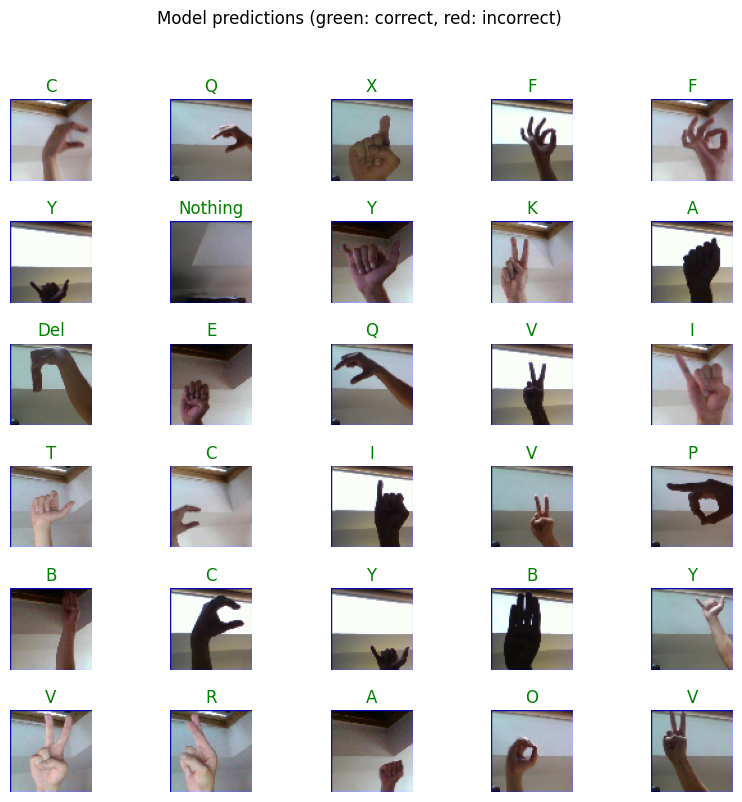

In [ ]:

# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# **Convert Model to TFLite**

In [ ]:
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/asl.tflite"
TFLITE_QUANT_MODEL = "tflite_models/asl_quant.tflite"

mkdir: cannot create directory ‘tflite_models’: File exists


In [ ]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : asl_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:
total 3.7M
-rw-r--r-- 1 root root 754K May 29 09:45 asl_quant.tflite
-rw-r--r-- 1 root root 3.0M May 29 09:45 asl.tflite


# Test with Custom Images

In [ ]:
os.chdir("/content")
from google.colab import files
uploaded = files.upload()

Saving download.jpg to download (2).jpg


In [ ]:
from tensorflow.keras.preprocessing import image
def getPrediction(path):
    img = image.load_img(path, target_size=(64,64))
    imgplot = plt.imshow(img)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    predicted = model.predict(images).squeeze()
    print(dataset_labels[np.argmax(predicted)])

1/1 [==============================] - 0s 101ms/step
K


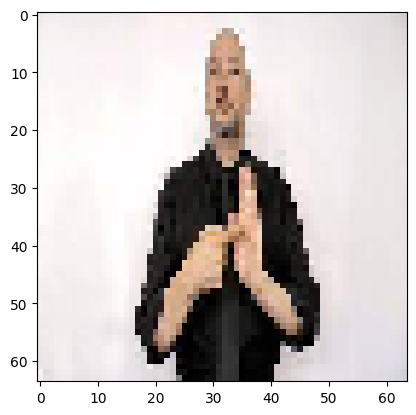

In [ ]:

getPrediction("download.jpg")
     